# Bayes' and kNN classifier from scratch

Okey let's get started by creating two images for the classifiers one mosly urban area and one forest area. I will reuse the code and data from previous labs, the area of Kraków's city center as urban representative and Puszcza Niepołomicka for forest area.

In [ ]:
#imports 
import numpy as np
import matplotlib.pyplot as plt
import glob
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import from_bounds
from pyproj import Transformer
from scipy.stats import norm, lognorm
from scipy.optimize import minimize

1.1. Create rgb of urban area

Found bands: {'B04': '/home/scoora/studies/ml/ML_for_space_tech/data/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/T34UDA_20241018T095031_B04_10m.jp2', 'B03': '/home/scoora/studies/ml/ML_for_space_tech/data/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/T34UDA_20241018T095031_B03_10m.jp2', 'B02': '/home/scoora/studies/ml/ML_for_space_tech/data/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/T34UDA_20241018T095031_B02_10m.jp2'}


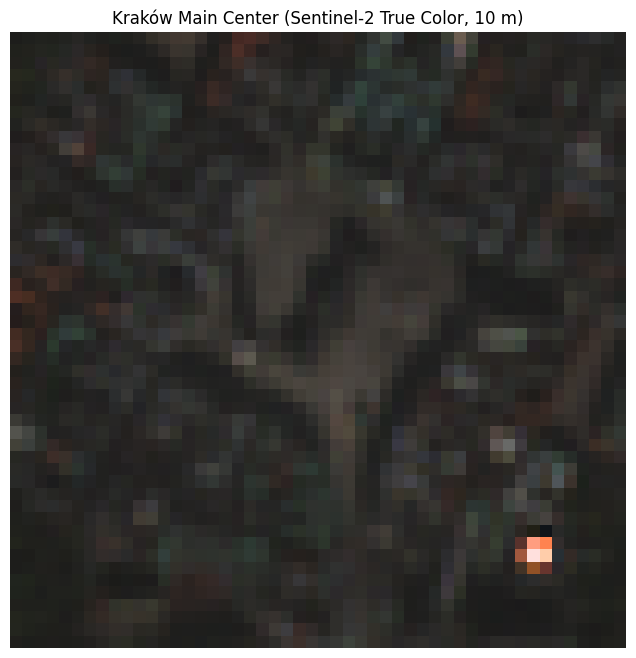

In [22]:
# path to the 10m bands 
folder = "/home/scoora/studies/ml/ML_for_space_tech/data/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/"
band_paths = {b: glob.glob(f"{folder}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}
print("Found bands:", band_paths)

# prepare to crop the image 
lon, lat = 19.93722, 50.06143   # Rynek Główny coordinates
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32634", always_xy=True)
x, y = transformer.transform(lon, lat)
dx = 250  
dy = 250 
xmin, ymin, xmax, ymax = x - dx, y - dy, x + dx, y + dy

# helper to read only crop
def read_crop(path, bounds):
    with rasterio.open(path) as src:
        window = from_bounds(*bounds, transform=src.transform)
        data = src.read(1, window=window)
    return data

# read and convert to surface reflectance (divide by 10000)
scale = 1.0 / 10000.0
b4_crop = read_crop(band_paths["B04"], (xmin, ymin, xmax, ymax)).astype(np.float32) * scale  # Red
b3_crop = read_crop(band_paths["B03"], (xmin, ymin, xmax, ymax)).astype(np.float32) * scale  # Green
b2_crop = read_crop(band_paths["B02"], (xmin, ymin, xmax, ymax)).astype(np.float32) * scale  # Blue

# stack 
rgb_crop_urban = np.dstack((b4_crop, b3_crop, b2_crop))

# visualize
plt.figure(figsize=(8, 8))
plt.imshow(np.clip(rgb_crop_urban, 0, 1))
plt.title("Kraków Main Center (Sentinel-2 True Color, 10 m)")
plt.axis("off")
plt.show()


1.2. forest area with the same zoom so the images are the same size:


Found bands: {'B04': '/home/scoora/studies/ml/ML_for_space_tech/data/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/T34UDA_20241018T095031_B04_10m.jp2', 'B03': '/home/scoora/studies/ml/ML_for_space_tech/data/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/T34UDA_20241018T095031_B03_10m.jp2', 'B02': '/home/scoora/studies/ml/ML_for_space_tech/data/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/T34UDA_20241018T095031_B02_10m.jp2'}


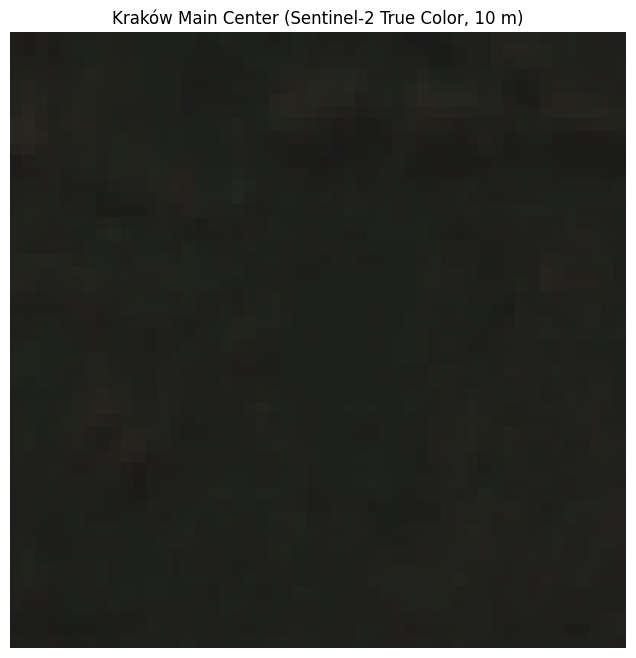

In [23]:
# path to the 10m bands 
folder = "/home/scoora/studies/ml/ML_for_space_tech/data/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/"
band_paths = {b: glob.glob(f"{folder}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}
print("Found bands:", band_paths)

# prepare to crop the image 
lon, lat = 20.3591, 50.0197  # Rynek Główny coordinates
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32634", always_xy=True)
x, y = transformer.transform(lon, lat)
dx = 250  
dy = 250 
xmin, ymin, xmax, ymax = x - dx, y - dy, x + dx, y + dy

# helper to read only crop
def read_crop(path, bounds):
    with rasterio.open(path) as src:
        window = from_bounds(*bounds, transform=src.transform)
        data = src.read(1, window=window)
    return data

# read and convert to surface reflectance (divide by 10000)
scale = 1.0 / 10000.0
b4_crop = read_crop(band_paths["B04"], (xmin, ymin, xmax, ymax)).astype(np.float32) * scale  # Red
b3_crop = read_crop(band_paths["B03"], (xmin, ymin, xmax, ymax)).astype(np.float32) * scale  # Green
b2_crop = read_crop(band_paths["B02"], (xmin, ymin, xmax, ymax)).astype(np.float32) * scale  # Blue

# stack 
rgb_crop_forest = np.dstack((b4_crop, b3_crop, b2_crop))

# visualize
plt.figure(figsize=(8, 8))
plt.imshow(np.clip(rgb_crop_forest, 0, 1))
plt.title("Kraków Main Center (Sentinel-2 True Color, 10 m)")
plt.axis("off")
plt.show()



For the image we want the classification be done on we will use bigger image of Kraków:

Found bands: {'B04': '/home/scoora/studies/ml/ML_for_space_tech/data/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/T34UDA_20241018T095031_B04_10m.jp2', 'B03': '/home/scoora/studies/ml/ML_for_space_tech/data/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/T34UDA_20241018T095031_B03_10m.jp2', 'B02': '/home/scoora/studies/ml/ML_for_space_tech/data/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/T34UDA_20241018T095031_B02_10m.jp2'}


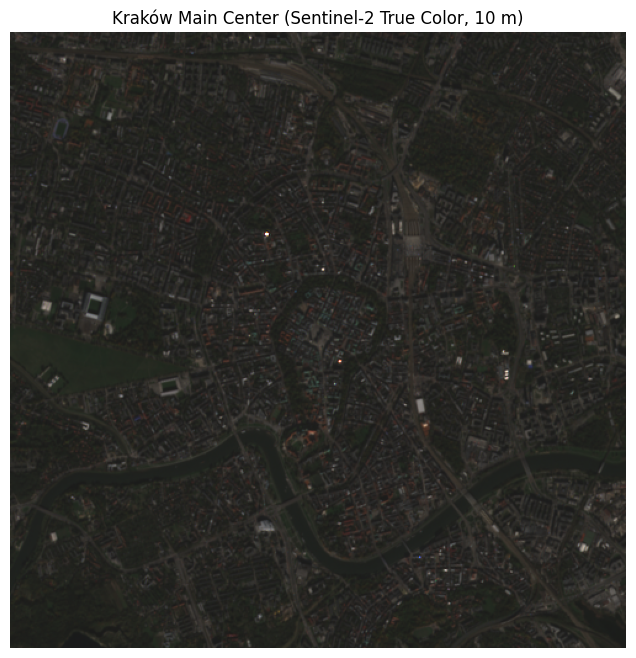

In [24]:
# path to the 10m bands 
folder = "/home/scoora/studies/ml/ML_for_space_tech/data/S2A_MSIL2A_20241018T095031_N0511_R079_T34UDA_20241018T124947.SAFE/GRANULE/L2A_T34UDA_A048696_20241018T095240/IMG_DATA/R10m/"
band_paths = {b: glob.glob(f"{folder}/*_{b}_10m.jp2")[0] for b in ["B04", "B03", "B02"]}
print("Found bands:", band_paths)

# prepare to crop the image 
lon, lat = 19.93722, 50.06143   # Rynek Główny coordinates
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32634", always_xy=True)
x, y = transformer.transform(lon, lat)
dx = 2500  
dy = 2500 
xmin, ymin, xmax, ymax = x - dx, y - dy, x + dx, y + dy

# helper to read only crop
def read_crop(path, bounds):
    with rasterio.open(path) as src:
        window = from_bounds(*bounds, transform=src.transform)
        data = src.read(1, window=window)
    return data

# read and convert to surface reflectance (divide by 10000)
scale = 1.0 / 10000.0
b4_crop = read_crop(band_paths["B04"], (xmin, ymin, xmax, ymax)).astype(np.float32) * scale  # Red
b3_crop = read_crop(band_paths["B03"], (xmin, ymin, xmax, ymax)).astype(np.float32) * scale  # Green
b2_crop = read_crop(band_paths["B02"], (xmin, ymin, xmax, ymax)).astype(np.float32) * scale  # Blue

# stack 
rgb_crop_all = np.dstack((b4_crop, b3_crop, b2_crop))

# visualize
plt.figure(figsize=(8, 8))
plt.imshow(np.clip(rgb_crop_all, 0, 1))
plt.title("Kraków Main Center (Sentinel-2 True Color, 10 m)")
plt.axis("off")
plt.show()


Okey now lets plot the histograms like those from labs before with fitted curves based on the suggested code form slides :)

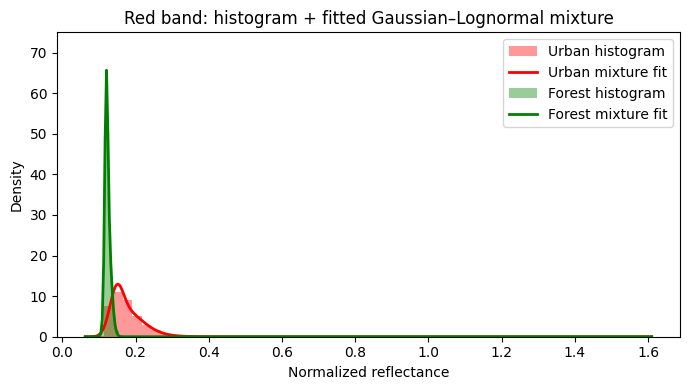


Red band parameters
Urban:  alpha=0.392, mu=0.148, sigma=0.018, m=-1.676, s=0.222
Forest: alpha=0.499, mu=0.120, sigma=0.004, m=-2.069, s=0.067


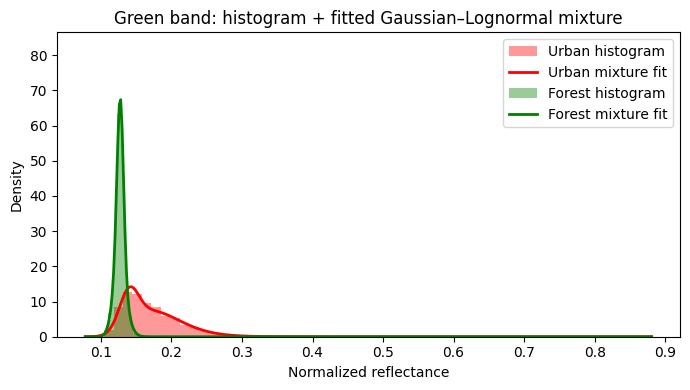


Green band parameters
Urban:  alpha=0.328, mu=0.140, sigma=0.013, m=-1.710, s=0.210
Forest: alpha=0.566, mu=0.128, sigma=0.005, m=-2.066, s=0.072


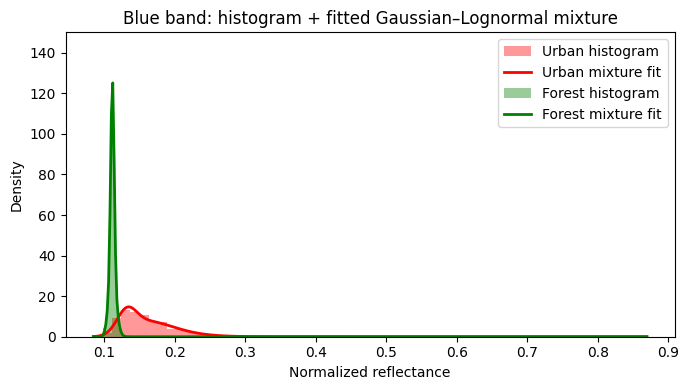


Blue band parameters
Urban:  alpha=0.339, mu=0.132, sigma=0.014, m=-1.773, s=0.212
Forest: alpha=0.578, mu=0.112, sigma=0.002, m=-2.192, s=0.047


In [25]:
# mixture model functions (same as slides) 
def mixture_pdf(x, alpha, mu, sigma, m, s):
    return alpha * norm.pdf(x, mu, sigma) + (1 - alpha) * lognorm.pdf(x, s, scale=np.exp(m))

def neg_log_likelihood(params, data):
    alpha, mu, sigma, m, s = params
    pdfs = mixture_pdf(data, alpha, mu, sigma, m, s)
    pdfs = np.maximum(pdfs, 1e-10)
    return -np.sum(np.log(pdfs))

# flatten the two images 
urban_pixels  = rgb_crop_urban.reshape(-1, 3)
forest_pixels = rgb_crop_forest.reshape(-1, 3)

band_names = ["Red", "Green", "Blue"]

# dictionaries to store parameters
params_urban = {}
params_forest = {}

# loop over bands
for i, band in enumerate(band_names):
    plt.figure(figsize=(7,4))
    udata = urban_pixels[:, i]
    fdata = forest_pixels[:, i]

    # URBAN 
    init = [0.5, np.mean(udata), np.std(udata),
            np.mean(np.log(udata + 1e-6)), np.std(np.log(udata + 1e-6))]
    bounds = [(0,1), (None,None), (1e-3,None), (None,None), (1e-3,None)]
    result_u = minimize(neg_log_likelihood, init, args=(udata,), bounds=bounds)
    params_urban[band] = tuple(result_u.x)  # store parameters
    a_u, mu_u, sig_u, m_u, s_u = result_u.x

    # plot urban
    xs = np.linspace(udata.min(), udata.max(), 400)
    plt.hist(udata, bins=60, density=True, alpha=0.4, color='r', label='Urban histogram')
    plt.plot(xs, mixture_pdf(xs, a_u, mu_u, sig_u, m_u, s_u), 'r', lw=2, label='Urban mixture fit')

    # FOREST 
    init = [0.5, np.mean(fdata), np.std(fdata),
            np.mean(np.log(fdata + 1e-6)), np.std(np.log(fdata + 1e-6))]
    result_f = minimize(neg_log_likelihood, init, args=(fdata,), bounds=bounds)
    params_forest[band] = tuple(result_f.x)  # store parameters
    a_f, mu_f, sig_f, m_f, s_f = result_f.x

    plt.hist(fdata, bins=60, density=True, alpha=0.4, color='g', label='Forest histogram')
    plt.plot(xs, mixture_pdf(xs, a_f, mu_f, sig_f, m_f, s_f), 'g', lw=2, label='Forest mixture fit')

    plt.xlabel("Normalized reflectance")
    plt.ylabel("Density")
    plt.title(f"{band} band: histogram + fitted Gaussian–Lognormal mixture")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # print summary
    print(f"\n{band} band parameters")
    print(f"Urban:  alpha={a_u:.3f}, mu={mu_u:.3f}, sigma={sig_u:.3f}, m={m_u:.3f}, s={s_u:.3f}")
    print(f"Forest: alpha={a_f:.3f}, mu={mu_f:.3f}, sigma={sig_f:.3f}, m={m_f:.3f}, s={s_f:.3f}")



As we can see the density per reflectance for each band and area are very different and the fitted line are very nice 

Bayes Classification on the larger Kraków image: 

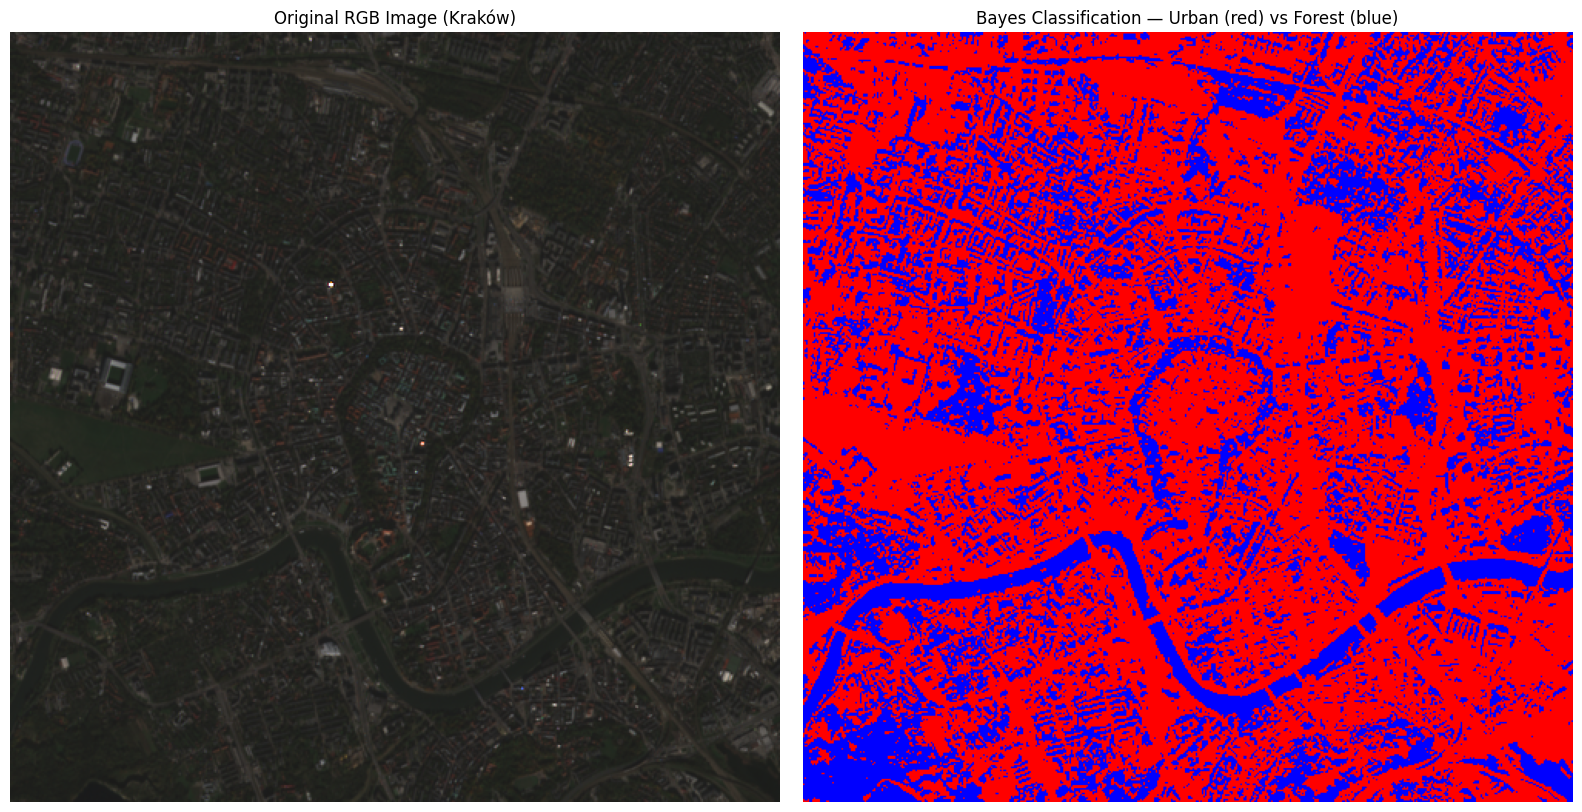

In [26]:
# STEP 1: function to compute log-likelihood per pixel for a class
def log_likelihood(rgb_img, params):
    eps = 1e-10
    ll = np.zeros(rgb_img.shape[:2], dtype=np.float32)
    for i, band in enumerate(["Red", "Green", "Blue"]):
        alpha, mu, sigma, m, s = params[band]
        band_vals = rgb_img[..., i]
        pdf = mixture_pdf(band_vals, alpha, mu, sigma, m, s)
        ll += np.log(np.maximum(pdf, eps))  # sum of log-likelihoods (Naive Bayes assumption)
    return ll

# STEP 3: compute log-likelihood maps for forest and urban 
ll_forest = log_likelihood(rgb_crop_all, params_forest)
ll_urban  = log_likelihood(rgb_crop_all, params_urban)

# STEP 4: Bayes decision rule (equal priors) 
pred_map = np.where(ll_urban > ll_forest, 1, 0)  # 1 = urban, 0 = forest

# STEP 5: colorize result 
H, W = pred_map.shape
classified_rgb = np.zeros((H, W, 3), dtype=np.uint8)
classified_rgb[pred_map == 1] = [255, 0, 0]   # red = urban
classified_rgb[pred_map == 0] = [0, 0, 255]   # blue = forest

# STEP 6: plot the result side by side with original RGB 
plt.figure(figsize=(16, 8))

# Left: original RGB
plt.subplot(1, 2, 1)
plt.imshow(np.clip(rgb_crop_all, 0, 1))
plt.title("Original RGB Image (Kraków)")
plt.axis("off")

# Right: classification map
plt.subplot(1, 2, 2)
plt.imshow(classified_rgb)
plt.title("Bayes Classification — Urban (red) vs Forest (blue)")
plt.axis("off")

plt.tight_layout()
plt.show()



Nice we can see that it almost corectly classifies the pixels, of course due to the sample size being small and that we have much more things then just forest and urban areas in the Kraków image, for example the Vistula river was classified as forest because the rgb bands look more like the forest bands then the urban bands and the same with Błonia area which is mosly grass it was classified as urban rather then forest. But the part of the forest in the bottom left corner and Planty are very nicely classified as well as the roads, bridges and the main square.

### KNN:

Training samples: (3000, 3)
Running k-NN with k=1 ...
Running k-NN with k=3 ...
Running k-NN with k=5 ...


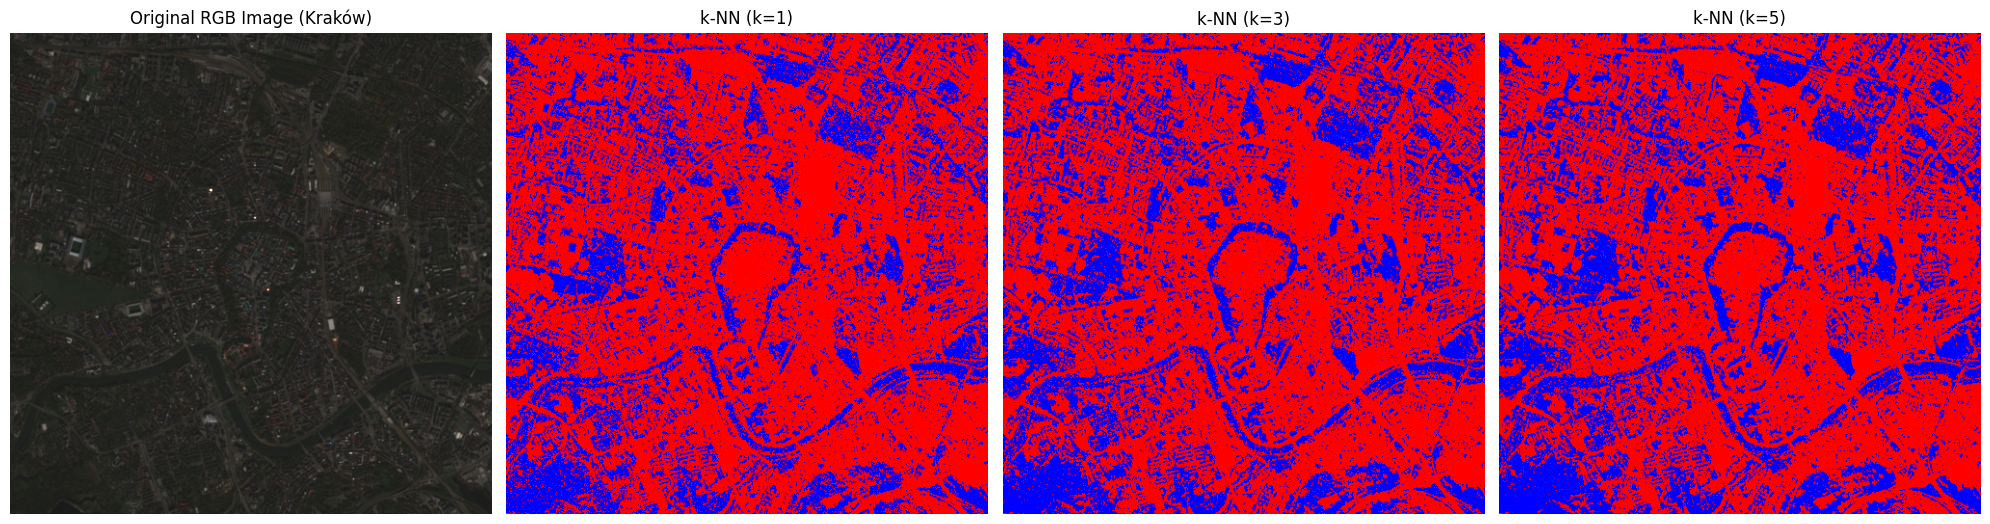

In [27]:
# Prepare training data (urban = 0, forest = 1)
def to_training(rgb, label, n_samples):
    flat = rgb.reshape(-1, 3)
    n = min(n_samples, flat.shape[0])
    idx = np.random.default_rng(123).choice(flat.shape[0], size=n, replace=False)
    X = flat[idx]
    y = np.full(X.shape[0], label, dtype=np.uint8)
    return X, y

# Subsample to keep memory reasonable
N_PER_CLASS = 1500
X_urban, y_urban = to_training(rgb_crop_urban, 0, N_PER_CLASS)   # 0 = urban (red)
X_forest, y_forest = to_training(rgb_crop_forest, 1, N_PER_CLASS)  # 1 = forest (blue)

# Merge training data
X_train = np.vstack([X_urban, X_forest]).astype(np.float32)
y_train = np.concatenate([y_urban, y_forest])
print("Training samples:", X_train.shape)

# Flatten test image (the big Kraków image)
H, W, _ = rgb_crop_all.shape
X_test = rgb_crop_all.reshape(-1, 3).astype(np.float32)

# k-NN classifier (with batching to avoid memory crash) 
def knn_predict(X_train, y_train, X_test, k=3, chunk=2048):
    """
    Predict class for each test pixel using k nearest neighbors (Euclidean distance).
    Processed in chunks to control memory use.
    """
    n_test = X_test.shape[0]
    y_pred = np.empty(n_test, dtype=np.uint8)
    for start in range(0, n_test, chunk):
        end = min(start + chunk, n_test)
        T = X_test[start:end]  # (chunk, 3)
        diffs = T[:, None, :] - X_train[None, :, :]
        d2 = np.sum(diffs * diffs, axis=2)
        nn_idx = np.argpartition(d2, kth=k-1, axis=1)[:, :k]
        nn_labels = y_train[nn_idx]
        votes_forest = np.sum(nn_labels == 1, axis=1)
        y_pred[start:end] = (votes_forest > (k // 2)).astype(np.uint8)
    return y_pred

# Run k-NN for k = 1, 3, 5
pred_maps = {}
for k in (1, 3, 5):
    print(f"Running k-NN with k={k} ...")
    preds = knn_predict(X_train, y_train, X_test, k=k, chunk=1024)
    pred_maps[k] = preds.reshape(H, W)

# Plot results side by side with original RGB 
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

# Left: original RGB
axes[0].imshow(np.clip(rgb_crop_all, 0, 1))
axes[0].set_title("Original RGB Image (Kraków)")
axes[0].axis("off")

# Right: kNN classification maps
for i, k in enumerate([1, 3, 5], start=1):
    pred_map = pred_maps[k]
    classified_rgb = np.zeros((H, W, 3), dtype=np.uint8)
    classified_rgb[pred_map == 1] = [0, 0, 255]   # 1 = forest (blue)
    classified_rgb[pred_map == 0] = [255, 0, 0]   # 0 = urban (red)

    axes[i].imshow(classified_rgb)
    axes[i].set_title(f"k-NN (k={k})")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


nice, the knn worked, its less precise then bayesm there are more "dust" like speckles inside big patches of one classification, like the forest on the bottom left. the planty are also less precisely classified but all in all the results are simmilar to the bayes. increasing the k value makes the algorithm more "precise" but its hard to see on these image one thing that differs is the speckles visible on planty or the big blue patch in the top right. 